# Mapping the Networks

Mapping the networks with the location of the nodes as their latitude and longitude locations.

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from mpl_toolkits.basemap import Basemap as Basemap
from shapely.geometry import Point

In [3]:
# read in the csv with the fishing vessel info
fvs = pd.read_csv("../data/geo_ais_rfv_all.csv")

# add in the data for fishing vessel areas
areas = pd.read_csv('../data/fishing_areas_geo.csv')

# combine datasets
all_data = pd.merge(fvs, areas,left_on = 'fishing_area', right_on='short_name')
all_data.dropna()

print(all_data.head())

  flag     vessel_name  fishing_hours   fishing_area  \
0  CHN    DONG YU 1521          22.86           hsp7   
1  CHN    DONG YU 1521         291.10           hsp6   
2  CHN    DONG YU 1521        1421.71   kirbati2_eez   
3  CHN    DONG YU 1521         741.84  kiribati1_eez   
4  CHN  FENG XIANG 818          12.19      nauru_eez   

                                     owner   vessel_type  \
0  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
1  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
2  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
3  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
4    Ningbo Yongfa Ocean Fisheries CO.,LTD  Purse seiner   

                                       owner_address owner_providence_state  \
0  Room 503, 5F, Building 1, No. 1 Xingye Road, G...               Zhejiang   
1  Room 503, 5F, Building 1, No. 1 Xingye Road, G...               Zhejiang   
2  Room 503, 5F, Building 1, No. 1 Xingye Road, G...             

## Fishing Area to Home Port

In [82]:
G = nx.from_pandas_edgelist(all_data, source = 'home_port_name', target = 'GEONAME',
                        edge_attr = 'fishing_hours')

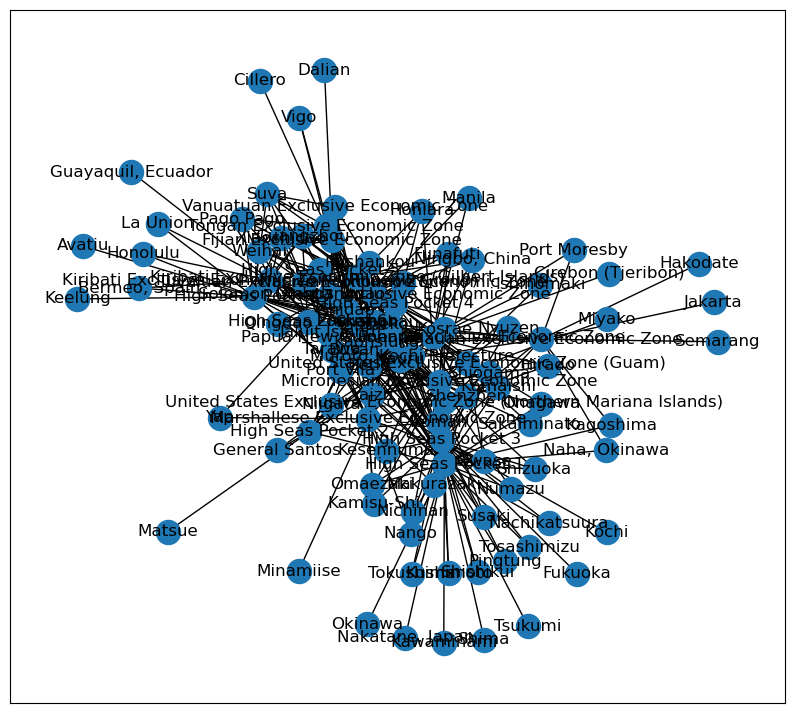

In [83]:
plt.figure(figsize = (10,9))
nx.draw_networkx(G)
plt.show()

In [ ]:
# Preprocess locations data

# Convert western hemisphere longitudes for Pacific-centered view
# This must be done because the map is flipped contrary to most projectsion
def adjust_longitude_for_pacific(lon):
    """Convert longitude to Pacific-centered view (0-360° system)"""
    return lon if lon >= 0 else lon + 360

# Get unique nodes for each type
home_ports = all_data[['home_port_name', 'home_port_longitude', 'home_port_latitude']].drop_duplicates()
fishing_areas = all_data[['GEONAME', 'fishing_area_long', 'fishing_area_lat']].drop_duplicates()

# Apply to your data before transformation
home_ports_adj = home_ports.copy()
fishing_areas_adj = fishing_areas.copy()

home_ports_adj['home_port_longitude'] = home_ports_adj['home_port_longitude'].apply(adjust_longitude_for_pacific)
fishing_areas_adj['fishing_area_long'] = fishing_areas_adj['fishing_area_long'].apply(adjust_longitude_for_pacific)


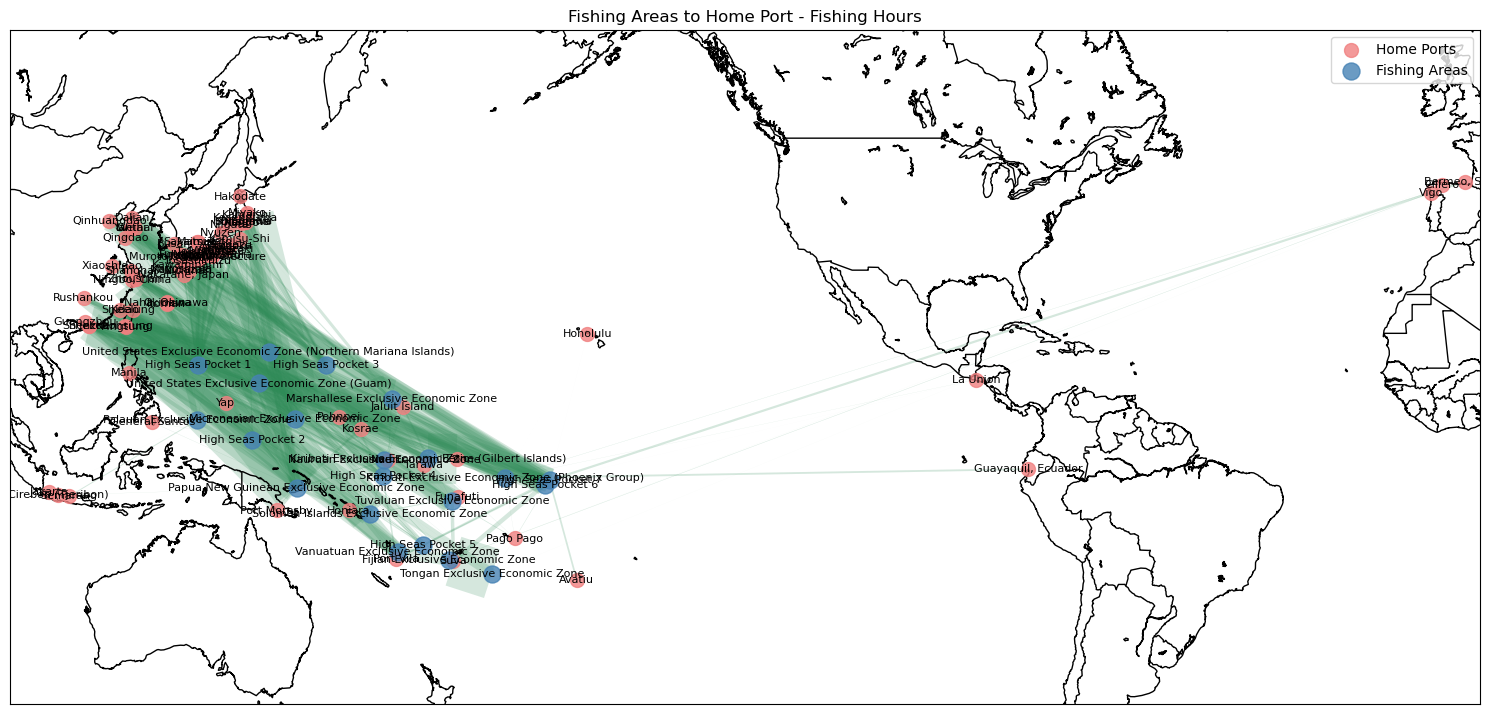

In [96]:
# create map size
plt.figure(figsize=(15,9))

# import base map with proper demarcations
m = Basemap(
    projection='merc',
    llcrnrlon=100,
    llcrnrlat=-40,
    urcrnrlon=360,
    urcrnrlat=60,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

# draw the map boundaries
m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth=1)

## Now add in the graph data

# Adjust coordinates to the same CRS as the basemap
mx_ports, my_ports = m(home_ports_adj['home_port_longitude'].values, home_ports_adj['home_port_latitude'].values)
mx_areas, my_areas = m(fishing_areas_adj['fishing_area_long'].values, fishing_areas_adj['fishing_area_lat'].values)

# Create separate position dictionaries for the two types of nodes
pos_ports = {port: (mx_ports[i], my_ports[i]) for i, port in enumerate(home_ports['home_port_name'])}
pos_areas = {area: (mx_areas[i], my_areas[i]) for i, area in enumerate(fishing_areas['GEONAME'])}

# Draw the nodes
nx.draw_networkx_nodes(G, pos_ports, nodelist=list(pos_ports.keys()), 
                      node_color='lightcoral', alpha = 0.8, node_size=100, label='Home Ports')
nx.draw_networkx_nodes(G, pos_areas, nodelist=list(pos_areas.keys()), 
                      node_color='steelblue', alpha = 0.8, node_size=150, label='Fishing Areas')

# Combine positions
pos_combined = {**pos_ports, **pos_areas}
# Get edge weights and create a list of widths
edge_weights = nx.get_edge_attributes(G, 'fishing_hours')
widths = [edge_weights[edge]/100 for edge in G.edges()]
# draw the edges
nx.draw_networkx_edges(G, pos = pos_combined, width=widths, edge_color='seagreen', alpha=0.2, arrows = False)

nx.draw_networkx_labels(G, pos_combined, font_size=8)
plt.legend()
plt.title("Fishing Areas to Home Port - Fishing Hours")
plt.tight_layout()
plt.show()

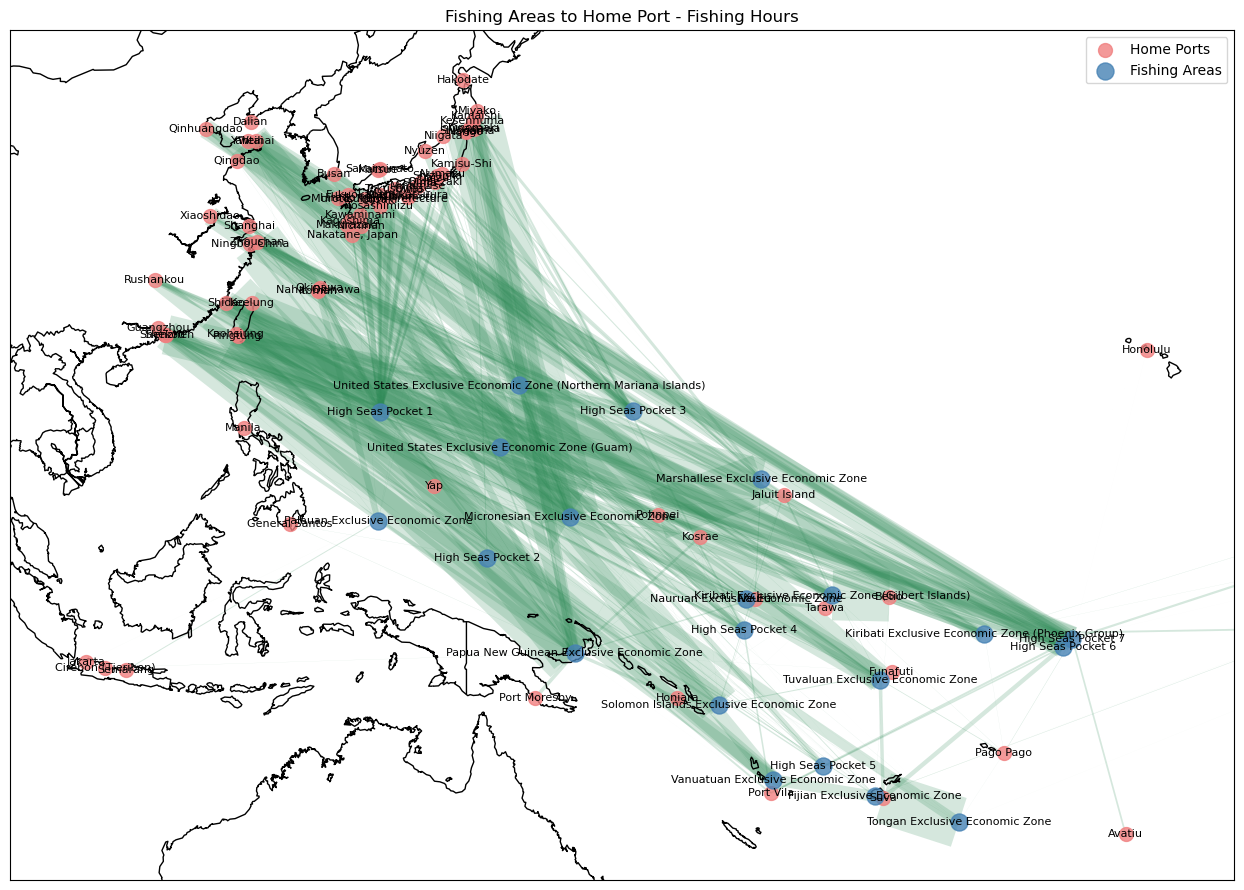

In [129]:
plt.figure(figsize=(15,9))
m = Basemap(
    projection='merc',
    llcrnrlon=100,
    llcrnrlat=-25,
    urcrnrlon=210,
    urcrnrlat=45,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth=1)


# Adjust coordinates to the same CRS as the basemap
mx_ports, my_ports = m(home_ports_adj['home_port_longitude'].values, home_ports_adj['home_port_latitude'].values)
mx_areas, my_areas = m(fishing_areas_adj['fishing_area_long'].values, fishing_areas_adj['fishing_area_lat'].values)

# Create separate position dictionaries for the two types of nodes
pos_ports = {port: (mx_ports[i], my_ports[i]) for i, port in enumerate(home_ports['home_port_name'])}
pos_areas = {area: (mx_areas[i], my_areas[i]) for i, area in enumerate(fishing_areas['GEONAME'])}

# Draw the nodes
nx.draw_networkx_nodes(G, pos_ports, nodelist=list(pos_ports.keys()), 
                      node_color='lightcoral', alpha = 0.8, node_size=100, label='Home Ports')
nx.draw_networkx_nodes(G, pos_areas, nodelist=list(pos_areas.keys()), 
                      node_color='steelblue', alpha = 0.8, node_size=150, label='Fishing Areas')

# Combine positions
pos_combined = {**pos_ports, **pos_areas}
# Get edge weights and create a list of widths
edge_weights = nx.get_edge_attributes(G, 'fishing_hours')
widths = [edge_weights[edge]/100 for edge in G.edges()]
# draw the edges
nx.draw_networkx_edges(G, pos = pos_combined, width=widths, edge_color='seagreen', alpha=0.2, arrows = False)

nx.draw_networkx_labels(G, pos_combined, font_size=8)
plt.legend()
plt.title("Fishing Areas to Home Port - Fishing Hours")
plt.tight_layout()
plt.show()

## Home Port to Owner Location

I realized that a lot of the owner locations were not standardized during the cleaning process. Im going to assign a location based on the lat and long and lists of the centers of countys/providinces/prefunctures/districts ect.

In [72]:
# load a shape file from Rnaturalearth that has the states and provices
provs = gpd.read_file('geo_files/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

# just the countries we need
countries = ['CN', 'CK', 'EC', 'ES', 'FJ', 'FM', 'ID', 'JP', 'KI', 'KR',
 'MH', 'NR', 'PH', 'PG', 'SB', 'SV', 'TV', 'TW', 'VU', 'US']
df = provs[provs['iso_a2'].isin(countries)]

# transorm the CRS
df_proj = df.to_crs(epsg=3857)

# compute centroids in projected coordinates
df_proj['centroid'] = df_proj.geometry.centroid

# convert back to lat/lon (EPSG:4326)
df['centroid'] = df_proj['centroid'].to_crs(epsg=4326)

# compute the lat and long
df['latitude'] = df.centroid.y
df['longitude'] = df.centroid.x

# turn it into a dataframe
centroids = pd.DataFrame({
    'country_iso': df['iso_a2'],
    'admin_name': df['name'],
    'prov_latitude': df['latitude'],
    'prov_longitude': df['longitude']
})

print(centroids)


     country_iso        admin_name  prov_latitude  prov_longitude
2             ID  Kalimantan Timur       1.354062      116.384015
16            CN          Xinjiang      41.098838       85.189305
17            CN            Xizang      31.686398       88.118474
49            KR           Gangwon      37.665875      128.342706
51            KR          Gyeonggi      37.526232      127.122071
...          ...               ...            ...             ...
4542          ES       Guadalajara      40.814237       -2.622955
4543          ES              Jaén      38.019559       -3.441530
4544          ES            Madrid      40.495051       -3.717082
4545          ES           Segovia      41.171403       -4.053635
4546          ES        Valladolid      41.635270       -4.848192

[484 rows x 4 columns]


/Users/merho/miniconda3/envs/geo_pandas/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000gn/T/ipykernel_74476/1408435612.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['latitude'] = df.centroid.y
/var/folders/9r/1lhfzshj5bvf1d4ybbng0kr00000gn/T/ipykernel_74476/1408435612.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lo

In [117]:
import geopandas as gpd
from shapely.geometry import Point

# Load the province/state shape file
provinces = gpd.read_file('geo_files/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
# keep only the columsn we want
provinces = provinces[['name', 'iso_a2','geometry']]

# Convert points to GeoDataFrame
geometry = [Point(xy) for xy in zip(all_data.owner_longitude, all_data.owner_latitude)]
geo_data = gpd.GeoDataFrame(all_data, geometry=geometry, crs="EPSG:4326")

print(geo_data)


     flag     vessel_name  fishing_hours         fishing_area  \
0     CHN    DONG YU 1521          22.86                 hsp7   
1     CHN    DONG YU 1521         291.10                 hsp6   
2     CHN    DONG YU 1521        1421.71         kirbati2_eez   
3     CHN    DONG YU 1521         741.84        kiribati1_eez   
4     CHN  FENG XIANG 818          12.19            nauru_eez   
...   ...             ...            ...                  ...   
2293  VUT     WIN WIN 707           1.02  solomon_islands_eez   
2294  VUT  YI SHUN NO.102         136.10                 hsp2   
2295  VUT  YI SHUN NO.102           0.32                 hsp1   
2296  VUT  YI SHUN NO.102         112.04                 hsp4   
2297  VUT  YI SHUN NO.102         114.98                 hsp6   

                                        owner        vessel_type  \
0     Zhejiang Xingpeng Ocean Fishery CO.,LTD          Longliner   
1     Zhejiang Xingpeng Ocean Fishery CO.,LTD          Longliner   
2     Zhejiang 

In [118]:
# spatial join
all_data_geo = gpd.sjoin(geo_data, provinces, how="left", predicate="within")
print(len(all_data_geo))
print(all_data_geo.isna().sum())


2298
flag                            0
vessel_name                     0
fishing_hours                   0
fishing_area                    0
owner                           0
vessel_type                     0
owner_address                   0
owner_providence_state         47
owner_country                  47
owner_latitude                 58
owner_longitude                61
home_port_name                  0
home_port_providence_state      0
home_port_country               0
home_port_latitude              0
home_port_longitude             0
GEONAME                         0
short_name                      0
geometry                        0
fishing_area_long               0
fishing_area_lat                0
index_right                   862
name                          862
iso_a2                        862
dtype: int64


After looking at the rows that had NaNs for the owner provinces, they appear to be from primarily:
Zhejiang, CHN,  Pingtung, TWN, and Shenzhen, CHN

I will go in and do those manually.
I will also update owner lat and long.

In [119]:
# strip the word 'province' from owner province for better matching
all_data['owner_providence_state'] = all_data['owner_providence_state'].str.replace(" Province", "", regex=False).str.strip()

# for Zhejiang
z_mask = all_data_geo['owner_providence_state'].str.contains("Zhejiang", case=False, na=False)
z_mask_2 = all_data_geo['owner_address'].str.contains("Zhejiang", case=False, na=False)
all_data_geo.loc[z_mask, 'name'] = "Zhejiang"
all_data_geo.loc[z_mask_2, 'name'] = "Zhejiang"
# Pingtung
p_mask = all_data_geo['owner_providence_state'].str.contains("Pingtung", case=False, na=False)
all_data_geo.loc[p_mask, 'name'] = "Pingtung"
# Shenzhen
s_mask = all_data_geo['owner_providence_state'].str.contains("Shenzhen", case=False, na=False)
all_data_geo.loc[s_mask, 'name'] = "Shenzhen"
# Shandong
s_mask_2 = all_data_geo['owner_providence_state'].str.contains("Shandong", case=False, na=False)
all_data_geo.loc[s_mask_2, 'name'] = "Shandong"


# drop all that are NaN in name column
all_data_geo = all_data_geo[all_data_geo['name'].notna()]

# update owner lat and long
all_data_geo = pd.merge(all_data_geo, centroids, how = "left", left_on = "name", right_on= "admin_name")

all_data_geo.to_csv("test.csv")
print(all_data_geo.isna().sum())

flag                            0
vessel_name                     0
fishing_hours                   0
fishing_area                    0
owner                           0
vessel_type                     0
owner_address                   0
owner_providence_state          4
owner_country                   4
owner_latitude                 12
owner_longitude                12
home_port_name                  0
home_port_providence_state      0
home_port_country               0
home_port_latitude              0
home_port_longitude             0
GEONAME                         0
short_name                      0
geometry                        0
fishing_area_long               0
fishing_area_lat                0
index_right                   607
name                            0
iso_a2                        607
country_iso                    87
admin_name                     87
prov_latitude                  87
prov_longitude                 87
dtype: int64


In [126]:
# clean up the columns
owner_hp_area_df = all_data_geo[['flag', 'vessel_name', 'fishing_hours', 'vessel_type', 
        'home_port_name','home_port_providence_state', 'home_port_country', 'home_port_latitude','home_port_longitude', 
        'GEONAME', 'fishing_area_long', 'fishing_area_lat', 
        'admin_name', 'prov_latitude','prov_longitude']]

# clean up the column names after the merges
owner_hp_area_df.columns = ['flag', 'vessel_name', 'fishing_hours', 'vessel_type', 'home_port_name',
       'home_port_providence_state', 'home_port_country', 'home_port_latitude',
       'home_port_longitude', 'fishing_area_name', 'fishing_area_long',
       'fishing_area_lat', 'owner_prov_name', 'prov_latitude', 'prov_longitude']

print(owner_hp_area_df.columns)

# drop columsn where prov_latitude and prov_longitude are NaN
owner_hp_area_df = owner_hp_area_df[owner_hp_area_df['prov_latitude'].notna()]

Index(['flag', 'vessel_name', 'fishing_hours', 'vessel_type', 'home_port_name',
       'home_port_providence_state', 'home_port_country', 'home_port_latitude',
       'home_port_longitude', 'fishing_area_name', 'fishing_area_long',
       'fishing_area_lat', 'owner_prov_name', 'prov_latitude',
       'prov_longitude'],
      dtype='object')


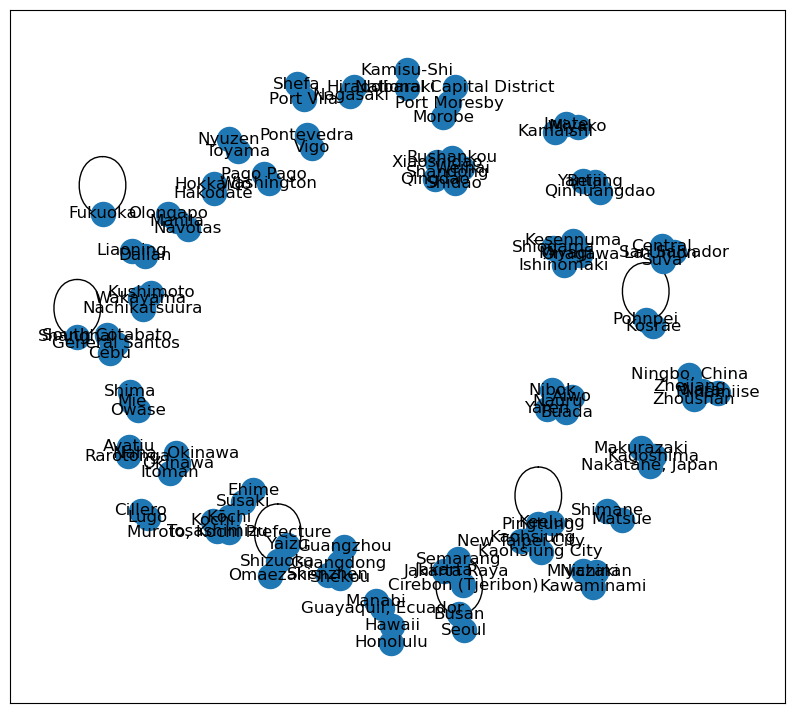

In [128]:
G = nx.from_pandas_edgelist(owner_hp_area_df, source = 'home_port_name', target = 'owner_prov_name')

plt.figure(figsize = (10,9))
nx.draw_networkx(G)
plt.show()

In [130]:
# Preprocess locations data

# Convert western hemisphere longitudes for Pacific-centered view
# This must be done because the map is flipped contrary to most projectsion
def adjust_longitude_for_pacific(lon):
    """Convert longitude to Pacific-centered view (0-360° system)"""
    return lon if lon >= 0 else lon + 360

# Get unique nodes for each type
home_ports = owner_hp_area_df[['home_port_name', 'home_port_longitude', 'home_port_latitude']].drop_duplicates()
owners = owner_hp_area_df[['owner_prov_name', 'prov_latitude', 'prov_longitude']].drop_duplicates()

# Apply to your data before transformation
home_ports_adj = home_ports.copy()
owners_adj = owners.copy()

home_ports_adj['home_port_longitude'] = home_ports_adj['home_port_longitude'].apply(adjust_longitude_for_pacific)
owners_adj['prov_longitude'] = owners_adj['prov_longitude'].apply(adjust_longitude_for_pacific)


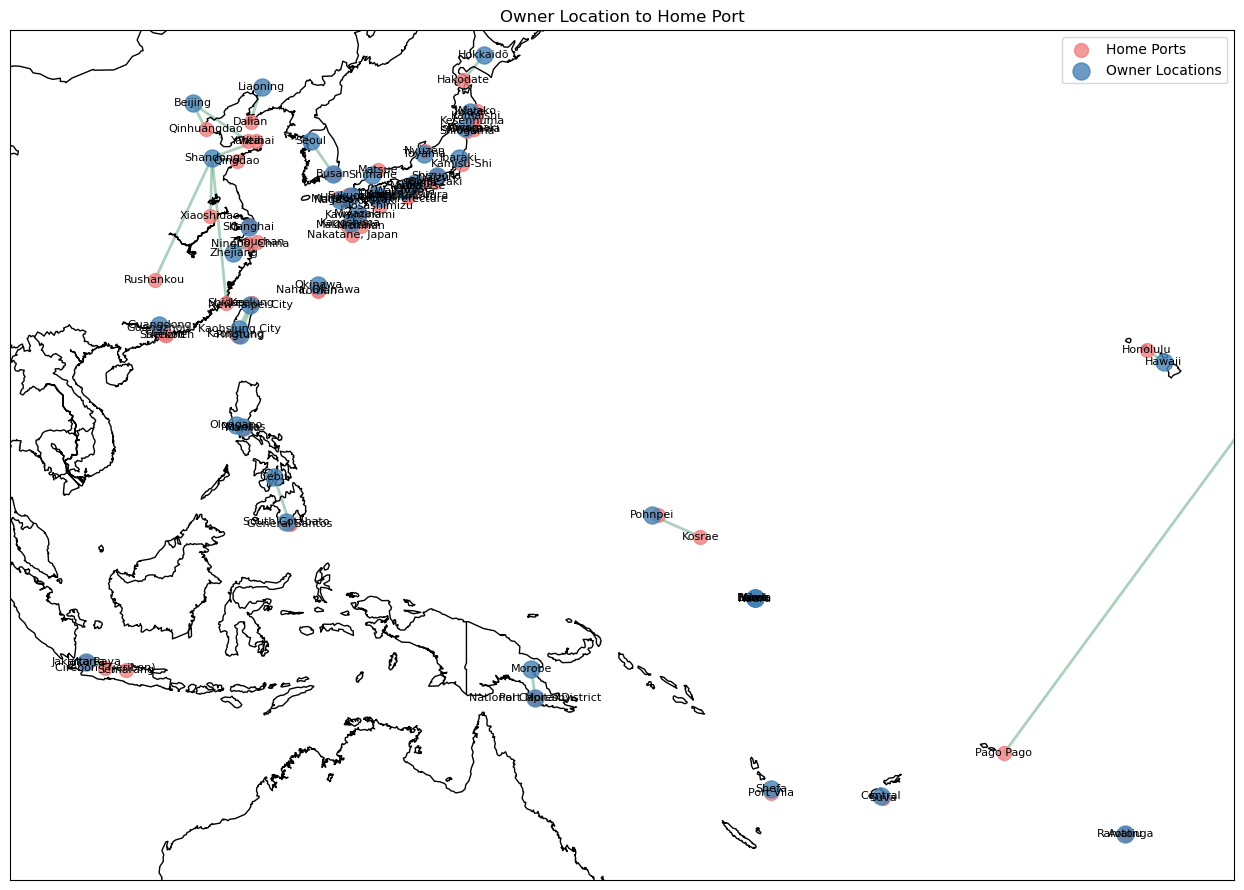

In [145]:
plt.figure(figsize=(15,9))
m = Basemap(
    projection='merc',
    llcrnrlon=100,
    llcrnrlat=-25,
    urcrnrlon=210,
    urcrnrlat=45,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth=1)


# Adjust coordinates to the same CRS as the basemap
mx_ports, my_ports = m(home_ports_adj['home_port_longitude'].values, home_ports_adj['home_port_latitude'].values)
mx_owners, my_owners = m(owners_adj['prov_longitude'].values, owners_adj['prov_latitude'].values)

# Create separate position dictionaries for the two types of nodes
pos_ports = {port: (mx_ports[i], my_ports[i]) for i, port in enumerate(home_ports['home_port_name'])}
pos_owner = {owner: (mx_owners[i], my_owners[i]) for i, owner in enumerate(owners['owner_prov_name'])}

# Draw the nodes
nx.draw_networkx_nodes(G, pos_ports, nodelist=list(pos_ports.keys()), 
                      node_color='lightcoral', alpha = 0.8, node_size=100, label='Home Ports')
nx.draw_networkx_nodes(G, pos_owner, nodelist=list(pos_owner.keys()), 
                      node_color='steelblue', alpha = 0.8, node_size=150, label='Owner Locations')

# Combine positions
pos_combined = {**pos_ports, **pos_owner}
# filter out self loops
edges_no_self_loops = [(u, v) for u, v in G.edges() if u != v]
# draw the edges
nx.draw_networkx_edges(G, pos = pos_combined, edgelist=edges_no_self_loops, edge_color='seagreen', 
                       width = 2, alpha=0.4, arrows = False)


# # Get edge weights and create a list of widths
# edge_weights = nx.get_edge_attributes(G, 'fishing_hours')
# widths = [edge_weights[edge]/100 for edge in G.edges()]

nx.draw_networkx_labels(G, pos_combined, font_size=8)
plt.legend()
plt.title("Owner Location to Home Port")
plt.tight_layout()
plt.show()